# 1. Loading Data and Libraries

In [2]:
from google.cloud import bigquery
from google.oauth2 import service_account
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

ModuleNotFoundError: No module named 'google'

In [ ]:
# Setup Google Cloud BigQuery API

# Replace with your own key path
key_path = "/Users/theodoreleeiv/Documents/Documents - Theodore’s MacBook Pro/Google Cloud/inbound-density-428819-p8-aef577a5f38e.json"
credentials = service_account.Credentials.from_service_account_file(key_path)

client = bigquery.Client()

def QUERY(query):
    """
    Queries BigQuery
    :param query: string
    :return: dataframe
    """
    query = str(query)
    query_job = client.query(query)
    return query_job.result().to_dataframe()


In [ ]:
# Create the overall readmissions table
mh_ed_readmissions_df = QUERY("""
WITH readmissions AS (
  SELECT 
    a.subject_id,
    a.stay_id AS index_stay_id,         -- First visit
    a.intime AS index_admit,
    a.outtime AS index_discharge,
    b.stay_id AS readmit_stay_id,       -- Readmission visit
    b.intime AS readmit_admit,
    b.outtime AS readmit_discharge,
    DATE_DIFF(b.intime, a.outtime, DAY) AS days_between
  FROM `physionet-data.mimiciv_ed.edstays` AS a
  JOIN `physionet-data.mimiciv_ed.edstays` AS b
    ON a.subject_id = b.subject_id
    AND a.stay_id != b.stay_id          -- Avoid self-matching
    AND b.intime > a.outtime            -- Ensure it's after discharge
    AND DATE_DIFF(b.intime, a.outtime, DAY) <= 30  -- Within 30 days
    AND DATE_DIFF(b.intime, a.outtime, DAY) > 0    -- Exclude same-day overlaps
)

SELECT 
  DISTINCT(ed.stay_id) AS stay_id,
  ed.subject_id,
  ed.hadm_id,
  r.readmit_stay_id,
  EXTRACT(DATE FROM intime) AS edadmitdate, -- admission date
  EXTRACT(HOUR FROM intime) AS edadmithour, -- admission hour
  EXTRACT(DATE FROM outtime) AS eddischargedate, -- discharge date
  EXTRACT(HOUR FROM outtime) AS eddischargehour, -- discharge hour
  DATE_DIFF(outtime,intime,hour) AS LOS_hr, -- length of stay in hours
  r.days_between AS days_to_readmission,

 -- Flag if this stay was followed by a readmission (index stay)
  CASE
    WHEN ed.stay_id IN (SELECT index_stay_id FROM readmissions) THEN 1
    ELSE 0
  END AS had_readmission_within_30,

  -- Flag if this stay IS a readmission
  CASE
    WHEN ed.stay_id IN (SELECT readmit_stay_id FROM readmissions) THEN 1
    ELSE 0
  END AS is_readmission,
  
  arrival_transport,
  disposition
FROM `physionet-data.mimiciv_ed.edstays` AS ed
LEFT JOIN
  readmissions AS r
ON
  ed.stay_id = r.readmit_stay_id
WHERE intime < outtime
ORDER BY subject_id ASC
""")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1933: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [ ]:
mh_ed_readmissions_df.head()

,stay_id,subject_id,hadm_id,readmit_stay_id,edadmitdate,edadmithour,eddischargedate,eddischargehour,LOS_hr,days_to_readmission,had_readmission_within_30,is_readmission,arrival_transport,disposition
0,32952584,10000032,29079034,32952584,2180-07-22,16,2180-07-23,5,13,26,1,1,AMBULANCE,HOME
1,33258284,10000032,22595853,<NA>,2180-05-06,19,2180-05-06,23,4,<NA>,0,0,AMBULANCE,ADMITTED
2,38112554,10000032,22841357,<NA>,2180-06-26,15,2180-06-26,21,6,<NA>,1,0,AMBULANCE,ADMITTED
3,35968195,10000032,25742920,35968195,2180-08-05,20,2180-08-06,1,5,13,0,1,AMBULANCE,ADMITTED
4,39399961,10000032,29079034,39399961,2180-07-23,5,2180-07-23,14,9,27,1,1,AMBULANCE,ADMITTED
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
457818,35692999,19999784,26194817,<NA>,2119-06-18,14,2119-06-18,21,7,<NA>,1,0,WALK IN,ADMITTED
457819,32917002,19999828,25744818,<NA>,2149-01-08,9,2149-01-08,18,9,<NA>,0,0,AMBULANCE,ADMITTED
457820,30712109,19999828,29734428,<NA>,2147-07-17,17,2147-07-18,17,24,<NA>,0,0,WALK IN,ADMITTED
457821,32002659,19999914,<NA>,<NA>,2158-12-24,11,2158-12-24,11,0,<NA>,0,0,UNKNOWN,ELOPED


In [ ]:
# Clean white style
sns.set_style("white")
# Set default palette color to red purple
sns.set_palette('RdPu')

In [ ]:
# 1. What age group has the highest readmission rate?
group_with_highest_readmission = QUERY("""
    SELECT
      p.age_group,
      AVG(r.days_to_readmission) AS avg_num_of_days_to_readmission,
      SUM(r.had_readmission_within_30)AS total_num_of_readmissions,
      ROUND((SUM(r.had_readmission_within_30)/COUNT(*)) * 100,2) AS percent_of_readmissions
    FROM
      `inbound-density-428819-p8.patient_info.MH-PATIENT-DEMO` AS p
    LEFT JOIN
      `inbound-density-428819-p8.patient_info.MH-ED-READMISSIONS` AS r
    ON
      r.subject_id = p.subject_id
    
    GROUP BY p.age_group
    ORDER BY total_num_of_readmissions DESC
""")

In [ ]:
group_with_highest_readmission

,age_group,avg_num_of_days_to_readmission,total_num_of_readmissions,percent_of_readmissions
0,50-59,14.372504,48553,34.12
1,40-49,14.309097,35576,30.98
2,60-69,14.615596,23967,22.47
3,20-29,13.514238,22651,20.54
4,30-39,13.837895,17990,21.63
5,70-79,14.316197,12148,18.44
6,80-89,14.441158,7288,17.29
7,90+,14.224252,1739,16.77
8,10-19,11.510876,1428,10.35
9,Unknown,11.571429,6,7.79


/var/folders/dl/r49548rn2gzfpg1c87vrjnvw0000gn/T/ipykernel_41850/1945870865.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
/var/folders/dl/r49548rn2gzfpg1c87vrjnvw0000gn/T/ipykernel_41850/1945870865.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)


Text(0.5, -0.12, ' \n    The two highest age groups with the highest proportion of readmissions were those aged 50-59 and 40-59, with proportions of\n    readmissions that were about 34% and 31%, respectively. These groups have significantly different proportions compared to other groups.\n    Additionally, it seems that the trend is that those in higher age groups take longer to readmit following a previous index admission compared to those in lower age groups. \n')

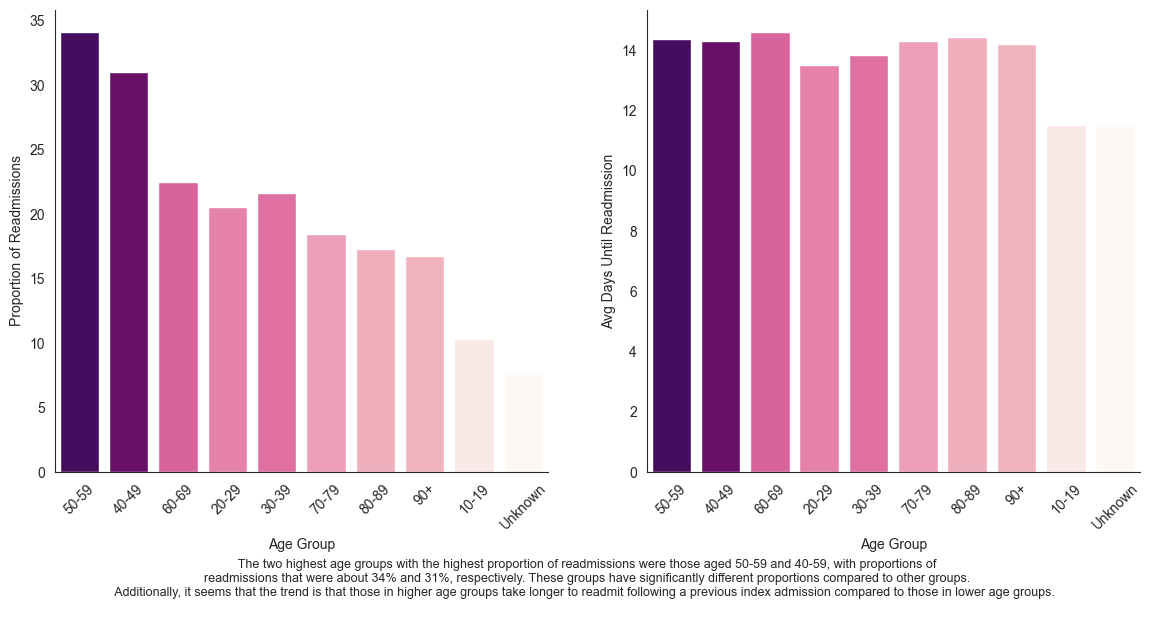

In [ ]:
fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(14,6))
sns.barplot(x="age_group", y="percent_of_readmissions",estimator='mean',hue ="percent_of_readmissions",palette='RdPu',data=group_with_highest_readmission,ax=ax1)
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.legend().set_visible(False)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
ax1.set_xlabel("Age Group")
ax1.set_ylabel("Proportion of Readmissions")

sns.barplot(x="age_group", y="avg_num_of_days_to_readmission",estimator='mean',hue ="avg_num_of_days_to_readmission", palette='RdPu',data=group_with_highest_readmission,ax=ax2)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.legend().set_visible(False)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
ax2.set_xlabel("Age Group")
ax2.set_ylabel("Avg Days Until Readmission")
caption = """ 
    The two highest age groups with the highest proportion of readmissions were those aged 50-59 and 40-59, with proportions of
    readmissions that were about 34% and 31%, respectively. These groups have significantly different proportions compared to other groups.
    Additionally, it seems that the trend is that those in higher age groups take longer to readmit following a previous index admission compared to those in lower age groups. 
"""
fig.text(0.5, -0.12,caption, ha='center', fontsize=9)

In [ ]:
#1.1 What are the readmission rates by age group and diagnosis?

age_groups_by_diagnosis = QUERY("""
SELECT
  p.age_group,
  d.mental_health_category,
  SUM(r.had_readmission_within_30) AS total_num_of_readmissions,
  ROUND((SUM(r.had_readmission_within_30)/COUNT(*)) * 100, 2) AS percent_of_readmissions
FROM
  `inbound-density-428819-p8.patient_info.MH-PATIENT-DEMO` AS p
LEFT JOIN
  `inbound-density-428819-p8.patient_info.MH-ED-READMISSIONS` AS r
ON
  r.subject_id = p.subject_id
LEFT JOIN
  `inbound-density-428819-p8.patient_info.MH-ED-DIAGNOSIS` AS d
ON
  r.stay_id = d.stay_id
GROUP BY
  p.age_group, d.mental_health_category
HAVING
  total_num_of_readmissions > 1
ORDER BY
  percent_of_readmissions DESC
""")

In [ ]:
age_groups_by_diagnosis = age_groups_by_diagnosis.pivot_table(index='age_group', columns='mental_health_category',values='percent_of_readmissions')

Text(0.5, 1.0, 'Percent of Readmissions by Age Group and Mental Health Diagnosis')

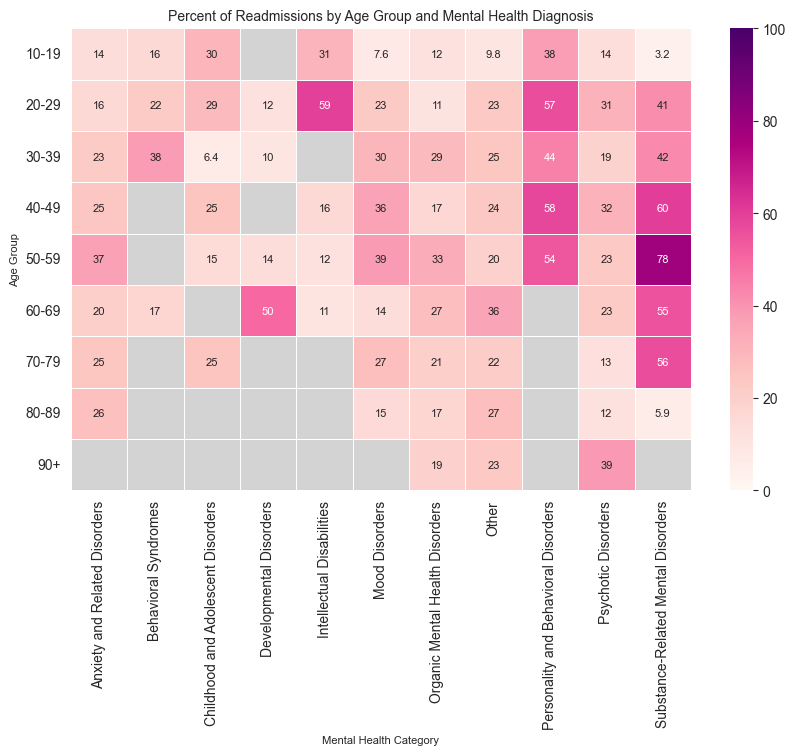

In [ ]:
# Create a mask for NaN values
mask = age_groups_by_diagnosis.isnull()

# Create a custom colormap where NaNs appear gray
cmap = sns.color_palette("RdPu", as_cmap=True)
cmap.set_bad(color='lightgray')  # Set NaNs to light gray
fig,ax = plt.subplots(figsize=(10,6))
# Plot the heatmap
sns.heatmap(age_groups_by_diagnosis, mask=mask, cmap=cmap, linewidths=0.5,ax=ax,annot=True,annot_kws=({'size':8}),vmin=0,vmax=100)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.set_title('')
ax.set_ylabel('Age Group', fontsize=8)
ax.set_xlabel('Mental Health Category', fontsize=8)
ax.set_title("Percent of Readmissions by Age Group and Mental Health Diagnosis", fontsize=10)

Overall, substance‑related disorders and personality disorders show the highest readmission rates across all age groups, suggesting these patients may be at particularly elevated risk. Notably, individuals in their 50s with a substance‑related diagnosis have a 78% readmission rate—far exceeding any other age‑diagnosis combination.

**Age‑specific highlights:**

**20s**: Among patients in their 20s, those diagnosed with intellectual disabilities exhibit the highest readmission rate compared to other diagnostic categories in this cohort.

**50s**: As noted, substance‑related disorders peak in this decade at 78%, underscoring the vulnerability of middle‑aged patients with these conditions.

**60s**: In patients aged 60, developmental disorders carry the highest readmission rate (50%), indicating a distinct risk pattern in later life.

**90s+**: In patients 90 and older, psychotic disorders have the highest readmission rate (39%), demonstrating that there is a higher risk for these patients as they get much older

These patterns suggest targeted interventions—particularly for substance‑related, personality, intellectual disability, developmental, and psychotic disorders, populations—could help reduce ED bounce‑backs in the highest‑risk age groups.

In [ ]:
# 1.2 What age group on average has the highest number of comorbities per patient?
age_groups_by_comorbities = QUERY("""
SELECT
    age_group,
    ROUND(avg(num_comorbities),1) AS avg_num_comorbitites
FROM
    (SELECT
      p.age_group,
      p.subject_id,
      Count(icd_code) AS num_comorbities
      
    FROM
      `inbound-density-428819-p8.patient_info.MH-PATIENT-DEMO` AS p
    LEFT JOIN
      `inbound-density-428819-p8.patient_info.MH-ED-READMISSIONS` AS r
    ON
      r.subject_id = p.subject_id
    LEFT JOIN
      `physionet-data.mimiciv_ed.diagnosis` AS d
    ON
      r.stay_id = d.stay_id
    WHERE d.seq_num > 1
    GROUP BY
      p.age_group,
      p.subject_id
        
    ORDER BY
      num_comorbities DESC) AS patient_counts
GROUP BY
  age_group
ORDER BY
  age_group;
  
""")

In [ ]:
age_groups_by_comorbities

,age_group,avg_num_comorbitites
0,10-19,2.4
1,20-29,3.2
2,30-39,4.4
3,40-49,7.3
4,50-59,7.4
5,60-69,6.8
6,70-79,6.1
7,80-89,5.9
8,90+,4.5
9,Unknown,3.8


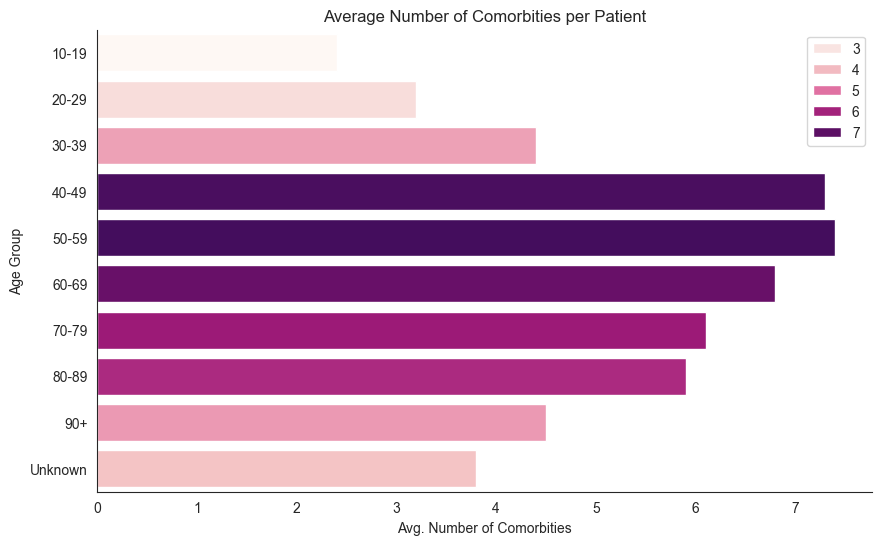

In [ ]:
fig,ax = plt.subplots(figsize=(10,6))
sns.barplot(data=age_groups_by_comorbities, x="avg_num_comorbitites", y="age_group",orient='h',hue="avg_num_comorbitites",palette='RdPu')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('Age Group')
ax.set_xlabel('Avg. Number of Comorbities')
ax.set_title('Average Number of Comorbities per Patient')
ax.legend()

Patients between the ages of 40 - 89, have a higher amount of comorbities on average compared to other age groups indicating that with advanced age more mental health diagnoses comorbities become more prevalent.

## Gender and Mental Health Diagnosis

In [ ]:
# 1.What gender has the highest readmission rate? 
gender_by_admission = QUERY("""
    SELECT
  gender,
  AVG(days_to_readmission) AS avg_readmissions,
  SUM(had_readmission_within_30) AS total_readmissions,
  ROUND((SUM(had_readmission_within_30)/COUNT(*))*100,2) AS percent_total_readmissions

FROM
  `inbound-density-428819-p8.patient_info.MH-ED-READMISSIONS` AS r

LEFT JOIN
  `inbound-density-428819-p8.patient_info.MH-PATIENT-DEMO` AS d

ON r.subject_id = d.subject_id



GROUP BY gender
ORDER BY total_readmissions DESC
""")
gender_by_admission

,gender,avg_readmissions,total_readmissions,percent_total_readmissions
0,M,14.139488,102063,30.32
1,F,14.276598,69283,19.63


Male patients have more readmissions compared to Women, 30.32% of male admissions to the emergency department are readmissions. The reason this is currently the case is still unclear but it might be due to the differences in the types of diagnosis male patients have versus female patients. Additionally, male patients may suffer from mental health diagnosis that are associated with greater readmission rates as we've seen with diagnosis related to substance abuse. 

In [ ]:
# 1.1 What are the top 10 diagnosis category by gender?
top_10_diagnosis_by_gender = QUERY("""
  SELECT
  gender,
  CASE
    WHEN mental_health_category IS NULL THEN 'Non-Mental Health Category'
    ELSE mental_health_category
  END as mental_health_category,
  AVG(days_to_readmission) AS avg_readmissions,
  SUM(had_readmission_within_30) AS total_readmissions,
  ROUND((SUM(had_readmission_within_30)/COUNT(*))*100,2) AS percent_total_readmissions


FROM
  `inbound-density-428819-p8.patient_info.MH-ED-READMISSIONS` AS r

LEFT JOIN
  `inbound-density-428819-p8.patient_info.MH-PATIENT-DEMO` AS d

ON r.subject_id = d.subject_id
LEFT JOIN
  `inbound-density-428819-p8.patient_info.MH-ED-DIAGNOSIS` AS dig

ON r.stay_id = dig.stay_id



GROUP BY gender,mental_health_category
ORDER BY gender DESC, percent_total_readmissions DESC
""")

In [ ]:
top_10_diagnosis_by_gender

,gender,mental_health_category,avg_readmissions,total_readmissions,percent_total_readmissions
0,M,Substance-Related Mental Disorders,14.115054,41759,66.75
1,M,Personality and Behavioral Disorders,14.341014,181,52.77
2,M,Mood Disorders,15.024588,3151,35.55
3,M,Psychotic Disorders,14.071588,1518,30.31
4,M,Intellectual Disabilities,18.112903,47,29.38
5,M,Anxiety and Related Disorders,13.243876,754,25.36
6,M,Childhood and Adolescent Disorders,14.512500,56,22.05
7,M,None,14.178958,57783,21.99
8,M,Organic Mental Health Disorders,12.227758,247,21.55
9,M,Other,12.856410,167,21.27
